<a href="https://colab.research.google.com/github/Ronin1289/Generating-Building-Drawings-Using-Image-Processing/blob/Experiments/EXPERIMENT_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DeepLSD

##Line Detection using Deep Learning

In [1]:
!git clone --recurse-submodules https://github.com/cvg/DeepLSD.git
%cd DeepLSD

Cloning into 'DeepLSD'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 266 (delta 29), reused 33 (delta 22), pack-reused 217 (from 1)
Receiving objects: 100% (266/266), 7.50 MiB | 21.87 MiB/s, done.
Resolving deltas: 100% (116/116), done.
Submodule 'line_refinement/pybind11' (https://github.com/pybind/pybind11) registered for path 'line_refinement/pybind11'
Submodule 'third_party/homography_est' (https://github.com/rpautrat/homography_est.git) registered for path 'third_party/homography_est'
Submodule 'third_party/progressive-x' (https://github.com/danini/progressive-x.git) registered for path 'third_party/progressive-x'
Submodule 'third_party/pytlbd' (https://github.com/iago-suarez/pytlbd.git) registered for path 'third_party/pytlbd'
Submodule 'third_party/pytlsd' (https://github.com/iago-suarez/pytlsd.git) registered for path 'third_party/pytlsd'
Cloning into '/content/DeepLSD/line

In [2]:
%cd DeepLSD

/content/DeepLSD


In [3]:
!bash quickstart_install.sh

Processing ./third_party/pytlsd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached brewer2mpl-1.4.1-py2.py3-none-any.whl.metadata (3.7 kB)
  Using cached kornia-0.8.0-py2.py3-none-any.whl.metadata (17 kB)
  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-p

In [4]:
import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py

In [5]:
import torch
print(torch.__version__)

2.5.1+cu124


In [1]:
!pip install omegaconf

In [6]:
!pip install pytlsd

In [7]:
!pip install flow_vis

In [8]:
!pip install pytorch as torch

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [9]:
from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines

In [22]:

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': False,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 3,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = '/content/drive/MyDrive/DATASETS/DeepLSD Weights/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu')
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

<ipython-input-22-0ae9692210a5>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(str(ckpt), map_location='cpu')


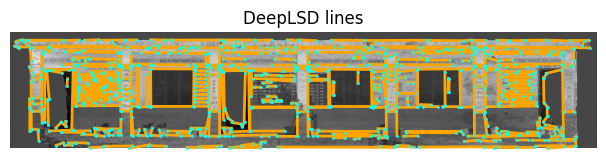

In [23]:
# Detect (and optionally refine) the lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([pred_lines], indices=range(1))

In [24]:
import cv2
img=cv2.imread('/content/sample_data/gsck2.png',cv2.IMREAD_GRAYSCALE)

In [25]:
gray_img=img.copy()

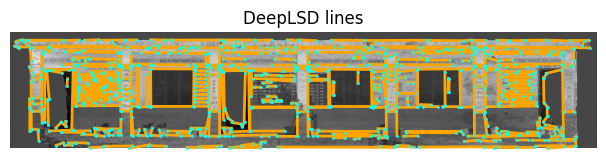

In [26]:
# Detect (and optionally refine) the lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([pred_lines], indices=range(1))



In [ ]:
print(type(pred_lines))
print(pred_lines.shape)
print(pred_lines[:5])

In [16]:
!pip install ezdxf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.4 MB/s eta 0:00:00


##Trying to fix lines by correcting them to 0 or 90 degrees

In [29]:
import math

def adjust_lines(pred_lines, threshold=5):
    adjusted_lines = []

    for (x1, y1), (x2, y2) in pred_lines:
        # Calculate the angle in degrees
        dx = x2 - x1
        dy = y2 - y1
        angle = math.degrees(math.atan2(dy, dx))  # atan2 returns angle in radians

        # Check if the angle is close to 0° (horizontal)
        if abs(angle) <= threshold or abs(angle - 180) <= threshold:
            # Make the line perfectly horizontal by setting y2 = y1
            y2 = y1

        # Check if the angle is close to 90° (vertical)
        elif abs(angle - 90) <= threshold or abs(angle + 90) <= threshold:
            # Make the line perfectly vertical by setting x2 = x1
            x2 = x1

        # Store the adjusted line
        adjusted_lines.append(((x1, y1), (x2, y2)))

    return adjusted_lines

# Example usage
adjusted_pred_lines = adjust_lines(pred_lines)


##Removing all skew lines

In [35]:
import math

def filter_horizontal_vertical_lines(pred_lines):
    filtered_lines = []

    for (x1, y1), (x2, y2) in pred_lines:
        dx = x2 - x1
        dy = y2 - y1

        # Check if the line is perfectly horizontal (dy == 0) or vertical (dx == 0)
        if dy == 0 or dx == 0:
            filtered_lines.append(((x1, y1), (x2, y2)))

    return filtered_lines

# Example usage
filtered_pred_lines = filter_horizontal_vertical_lines(adjusted_pred_lines)


##Merging close lines

In [39]:
import numpy as np
import math

def merge_lines(pred_lines, angle_threshold=5, distance_threshold=10):
    merged_lines = []
    used = [False] * len(pred_lines)  # Track which lines have been merged

    def angle_between_lines(line1, line2):
        """Calculate the angle difference between two lines."""
        (x1, y1), (x2, y2) = line1
        (x3, y3), (x4, y4) = line2
        angle1 = math.atan2(y2 - y1, x2 - x1)
        angle2 = math.atan2(y4 - y3, x4 - x3)
        return abs(math.degrees(angle1 - angle2))

    def distance(p1, p2):
        """Calculate Euclidean distance between two points."""
        return np.linalg.norm(np.array(p1) - np.array(p2))

    for i, line1 in enumerate(pred_lines):
        if used[i]:
            continue
        (x1, y1), (x2, y2) = line1
        for j, line2 in enumerate(pred_lines):
            if i == j or used[j]:
                continue
            (x3, y3), (x4, y4) = line2

            # Check if the lines are collinear (small angle difference)
            if angle_between_lines(line1, line2) < angle_threshold:
                # Check if endpoints are close enough to merge
                if (distance((x2, y2), (x3, y3)) < distance_threshold or
                    distance((x1, y1), (x4, y4)) < distance_threshold or
                    distance((x2, y2), (x4, y4)) < distance_threshold or
                    distance((x1, y1), (x3, y3)) < distance_threshold):

                    # Merge lines by taking the min and max x/y values
                    new_x1 = min(x1, x2, x3, x4)
                    new_y1 = min(y1, y2, y3, y4)
                    new_x2 = max(x1, x2, x3, x4)
                    new_y2 = max(y1, y2, y3, y4)

                    pred_lines[i] = ((new_x1, new_y1), (new_x2, new_y2))
                    used[j] = True  # Mark second line as merged

        merged_lines.append(pred_lines[i])

    return merged_lines

# Example usage
merged_pred_lines = merge_lines(filtered_pred_lines)


In [40]:
import ezdxf

# Create a new DXF document
doc = ezdxf.new()
msp = doc.modelspace()

# Find the maximum Y value to flip coordinates correctly
max_y = max(max(y1, y2) for (x1, y1), (x2, y2) in pred_lines)

# Add flipped lines to the DXF file
for line in filtered_pred_lines:
    (x1, y1), (x2, y2) = line
    msp.add_line((x1, max_y - y1), (x2, max_y - y2))

# Save the DXF file
doc.saveas("detected_lines.dxf")


In [41]:
from google.colab import files

# Specify the filename
filename = "detected_lines.dxf"

# Download the file
files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>